# Predict Student Performance from Game Play 🎼

## Description

The DS project is the Kaggle competition

https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview

**Goal**: to predict student perfomance during game-based learning in real-time.

- **DS problem type**: binary classification, tabular data.

- **Data type**: game logs (time series).

- **Submission**:

session_id / question number - binary label (correct/incorrect).

*Example*:

session_id,correct

20090109393214576_q1,0

20090312143683264_q1,0

20090312331414616_q1,0

- **Evaluation**: F1-score
$$
F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}
$$

### Dataset description

3 checkpoints:
- 📌 level 4
- 📌 level 12
- 📌 level 22

At each checkpoint we have access to all previous test data.

**18** questions for each sessions.

**Data format**:<br>
rows:<br>
`session_id`_`question #`

18 rows (questions) for each session

**To predict correctness of each segment**:

3 segments:
- 📌 0-4
- 📌 5-12
- 📌 13-22

#### Files

- `train.csv` - the training set
- `test.csv` - the test set
- `sample_submission.csv` - a sample submission file in the correct format
- `train_labels.csv` - correct value for all 18 questions for each session in the training set

#### Columns

- `session_id` - the ID of the session the event took place in
- `index` - the index of the event for the session
- `elapsed_time` - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- `event_name` - the name of the event type
- `name` - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- `level` - what level of the game the event occurred in (0 to 22)
- `page` - the page number of the event (only for notebook-related events)
- `room_coor_x` - the coordinates of the click in reference to the in-game room (only for click events)
- `room_coor_y` - the coordinates of the click in reference to the in-game room (only for click events)
- `screen_coor_x` - the coordinates of the click in reference to the player’s screen (only for click events)
- `screen_coor_y` - the coordinates of the click in reference to the player’s screen (only for click events)
- `hover_duration` - how long (in milliseconds) the hover happened for (only for hover events)
- `text` - the text the player sees during this event
- `fqid` - the fully qualified ID of the event
- `room_fqid` - the fully qualified ID of the room the event took place in
- `text_fqid` - the fully qualified ID of the text
- `fullscreen` - whether the player is in fullscreen mode
- `hq` - whether the game is in high-quality
- `music` - whether the game music is on or off
- `level_group` - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)


## Download the dataset from Kaggle

In [15]:
#!chmod 600 /Users/kuzmatsukanov/.kaggle/kaggle.json

# Download
#!kaggle competitions download -c predict-student-performance-from-game-play -p ./dataset

# Unzip
#!unzip dataset/predict-student-performance-from-game-play.zip -d ./dataset

## Import libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind"))

## Load data

In [21]:
df_labels = pd.read_csv('dataset/train_labels.csv')
df_train = pd.read_csv('dataset/train.csv')

## Exploratory Data Analysis

In [110]:
print('In train set')
print('Number of samples: {}'.format(df_train.shape[0]))
print('Number of features: {}'.format(df_train.shape[1]))
print('Number of labeled data: {}'.format(df_labels.shape[0]))

In train set
Number of samples: 26296946
Number of features: 20
Number of labeled data: 424116


In [20]:
df_train.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [23]:
df_train.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,2.629695e+07,2.629695e+07,2.629695e+07,2.629695e+07,564544.000000,2.422367e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.002244e+06,2.629695e+07,2.629695e+07,2.629695e+07
mean,2.113249e+16,6.445102e+02,4.016694e+06,1.219169e+01,3.166559,-5.490579e+01,-1.162119e+02,4.584098e+02,3.855860e+02,3.471003e+03,1.370037e-01,1.202047e-01,9.293778e-01
std,5.712953e+14,5.457880e+02,3.127032e+07,6.497789e+00,2.063291,5.202926e+02,2.184710e+02,2.479389e+02,1.298166e+02,4.602024e+05,3.438513e-01,3.252008e-01,2.561926e-01
min,2.009031e+16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181623e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.101022e+16,2.880000e+02,4.397000e+05,6.000000e+00,1.000000,-3.528395e+02,-2.127183e+02,2.690000e+02,3.040000e+02,9.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.104021e+16,5.950000e+02,1.014801e+06,1.300000e+01,3.000000,-1.116280e+01,-9.760534e+01,4.470000e+02,3.970000e+02,4.190000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.110052e+16,8.960000e+02,1.747040e+06,1.800000e+01,5.000000,2.966515e+02,2.268786e+01,6.630000e+02,4.710000e+02,1.266000e+03,0.000000e+00,0.000000e+00,1.000000e+00
max,2.210022e+16,2.047300e+04,1.988607e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08,1.000000e+00,1.000000e+00,1.000000e+00


In [24]:
# Get a Series of count of unique values in each column
unique_values = df_train.nunique()

In [25]:
unique_values

session_id           23562
index                20348
elapsed_time       5042639
event_name              11
name                     6
level                   23
page                     7
room_coor_x       17438693
room_coor_y       13651023
screen_coor_x        57924
screen_coor_y       102591
hover_duration       24101
text                   597
fqid                   128
room_fqid               19
text_fqid              126
fullscreen               2
hq                       2
music                    2
level_group              3
dtype: int64

### Missing values

In [42]:
count_missing_values = df_train.isna().sum()
count_missing_values = count_missing_values/df_train.shape[0]

In [76]:
count_missing_values_df = pd.DataFrame(count_missing_values[count_missing_values != 0].sort_values(ascending=True),
                                     columns=['Missing values']).round(2)

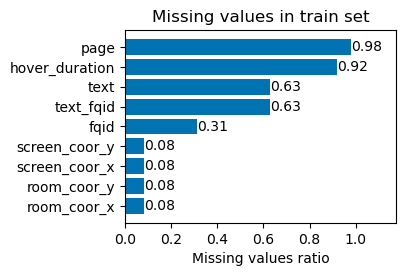

In [114]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bars = ax.barh(y=count_missing_values_df.index, width=count_missing_values_df['Missing values'])
ax.bar_label(container=bars, padding=0.1)
ax.margins(x=0.2)
ax.set_xlabel('Missing values ratio')
ax.set_title('Missing values in train set');